# Extract ObjectTables Results in  OGA

 work with Weakly_2024_07
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/21
- update : 2024/03/01


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2024_07/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2024_07/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2024_07/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+34187316c4 	current w_2024_07 setup


In [3]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize


from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from matplotlib.colors import ListedColormap

# LSST packages
from lsst.daf.butler import Butler
import lsst.geom as geom

# allow interactive plots
#%matplotlib widget
%matplotlib inline

# default plot style is accessible
plt.style.use('tableau-colorblind10')
import seaborn as sns

In [4]:
# A repo which exists at the USDF, contains data from various instruments and
REPO = '/repo/embargo'

from lsst.daf.butler import Butler
from pprint import pprint

# Here we specify a default collection to use
#my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240201/w_2024_05/PREOPS-4871"
butler = Butler(REPO, collections=my_collection)
registry = butler.registry

In [5]:
list(butler.registry.queryDimensionRecords('detector', where="instrument='LATISS' AND detector.id IN (0..8)"))

[detector.RecordClass(instrument='LATISS', id=0, full_name='RXX_S00', name_in_raft='RXX_S00', raft=None, purpose='SCIENCE')]

### access to skymap

https://github.com/sylvielsstfr/MyDP0LSS/blob/main/myDP0.2/TrackAndPatch/PlotTractAndPatchs_butler.ipynb

In [6]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

## Config

In [7]:
datasetRefs = butler.registry.queryDatasets(datasetType='skyMap', collections=my_collection, where= "instrument='LATISS'")

In [8]:
for i, ref in enumerate(datasetRefs):
    pprint(ref)
    skymap_id = ref.dataId["skymap"]
    if skymap_id ==  'latiss_v1':
        skymap = ref

DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'hsc_rings_v1'}, run='skymaps', id=6e7fc928-0dc3-4e1b-ae63-5fb63be46216)
DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'latiss_v1'}, run='skymaps', id=f677ff86-2b1c-4094-9dad-e39395052cd1)
DatasetRef(DatasetType('skyMap', {skymap}, SkyMap), {skymap: 'lsst_cells_v1'}, run='skymaps', id=857e0e80-8d08-44f4-a81b-84227b064d5b)


In [9]:
skymap = butler.get(ref)

In [10]:
my_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [11]:
#from lsst.daf.butler import Butler
#butler = Butler('SMALL_HSC')
skymap = butler.get('skyMap', skymap='latiss_v1', collections=my_collection)
tractInfo = skymap.generateTract(5616)
#patch = tractInfo[41]
#patch.getIndex()

In [12]:
#for patch in tractInfo:
#    print(patch.getSequentialIndex())

In [13]:
# Load data (deserialize)
import pickle
with open('../data/202402/Latiss_tractspatchs_202402.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [14]:
tracts_patchs_dict

{10644: array([189, 183, 184, 164, 185, 203, 201, 207, 182, 162, 166, 165, 181,
        161, 188, 208, 180, 202]),
 5634: array([ 90, 110,  71, 112,  73, 109,  93,  92,  91,  53,  72,  55,  52,
        111,  54,  74]),
 3863: array([223, 261, 241, 242, 262, 260, 243, 222, 224]),
 452: array([41, 62, 22, 25, 23, 44, 42, 63, 43, 24]),
 5614: array([250, 251, 230, 210, 212, 232, 211, 213, 249, 229, 231]),
 5616: array([355, 358, 316, 338, 356, 336, 357, 337, 317, 335, 315, 334]),
 5615: array([274, 331, 312, 332, 294, 295, 293, 313, 333, 314, 275, 276]),
 5839: array([9, 8, 7]),
 10643: array([190, 171]),
 455: array([51, 52, 15, 33, 14, 53, 34, 13, 32]),
 382: array([343, 344, 342]),
 3864: array([274, 238, 217, 218, 273, 255, 235, 275, 237, 257, 219, 236, 256,
        254, 276, 216]),
 383: array([359, 360])}

In [15]:
list_of_tracts = list(tracts_patchs_dict.keys())
list_of_tracts

[10644, 5634, 3863, 452, 5614, 5616, 5615, 5839, 10643, 455, 382, 3864, 383]

In [16]:
npatches = 0
for itract in list_of_tracts:
    npatches += len(tracts_patchs_dict[itract])
print(npatches)    

123


In [17]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

numTracts=0
# collection of polygons
patches = [] # container of all polygons


tract_polygon_dict = {}
tract_ra_dict = {}
tract_dec_dict = {}

# loop on tracts
#---------------
for tractInfo in skymap:
    tractID = tractInfo.getId()
    if tractID not in list_of_tracts:
        continue
    numTracts+=1  

    # container for each tract
    container_polygons_fortract = []
    container_ra_fortract = []
    container_dec_fortract = []


    # loop on patch
    #--------------
    for patch in tractInfo:
        patchID = patch.getSequentialIndex()
        if patchID not in tracts_patchs_dict[tractID]:
            continue
        ibb=patch.getInnerBBox()
        tWCS=tractInfo.getWcs()
        corners = []
        # loop on the 4 corners
        for icorn,corner in enumerate(ibb.getCorners()):
            p = geom.Point2D(corner.getX(), corner.getY())
            coord = tWCS.pixelToSky(p)
            corners.append([coord.getRa().asDegrees(), coord.getDec().asDegrees()])
            container_ra_fortract.append(coord.getRa().asDegrees()) 
            container_dec_fortract.append(coord.getDec().asDegrees()) 
        #print(f"==={numTracts}==={tractID}:{patchID}==========")    
        corners_array = np.array(corners)
        corners_array = np.append(corners_array,[corners_array[0]],axis=0)
        polygon = Polygon(corners_array,closed=True)
        patches.append(polygon)
        container_polygons_fortract.append(polygon)
        
        
    tract_polygon_dict[tractID] = container_polygons_fortract
    tract_ra_dict[tractID] = np.array(container_ra_fortract)
    tract_dec_dict[tractID] = np.array(container_dec_fortract)
        
print(numTracts)   



13


## Plot all tracts together

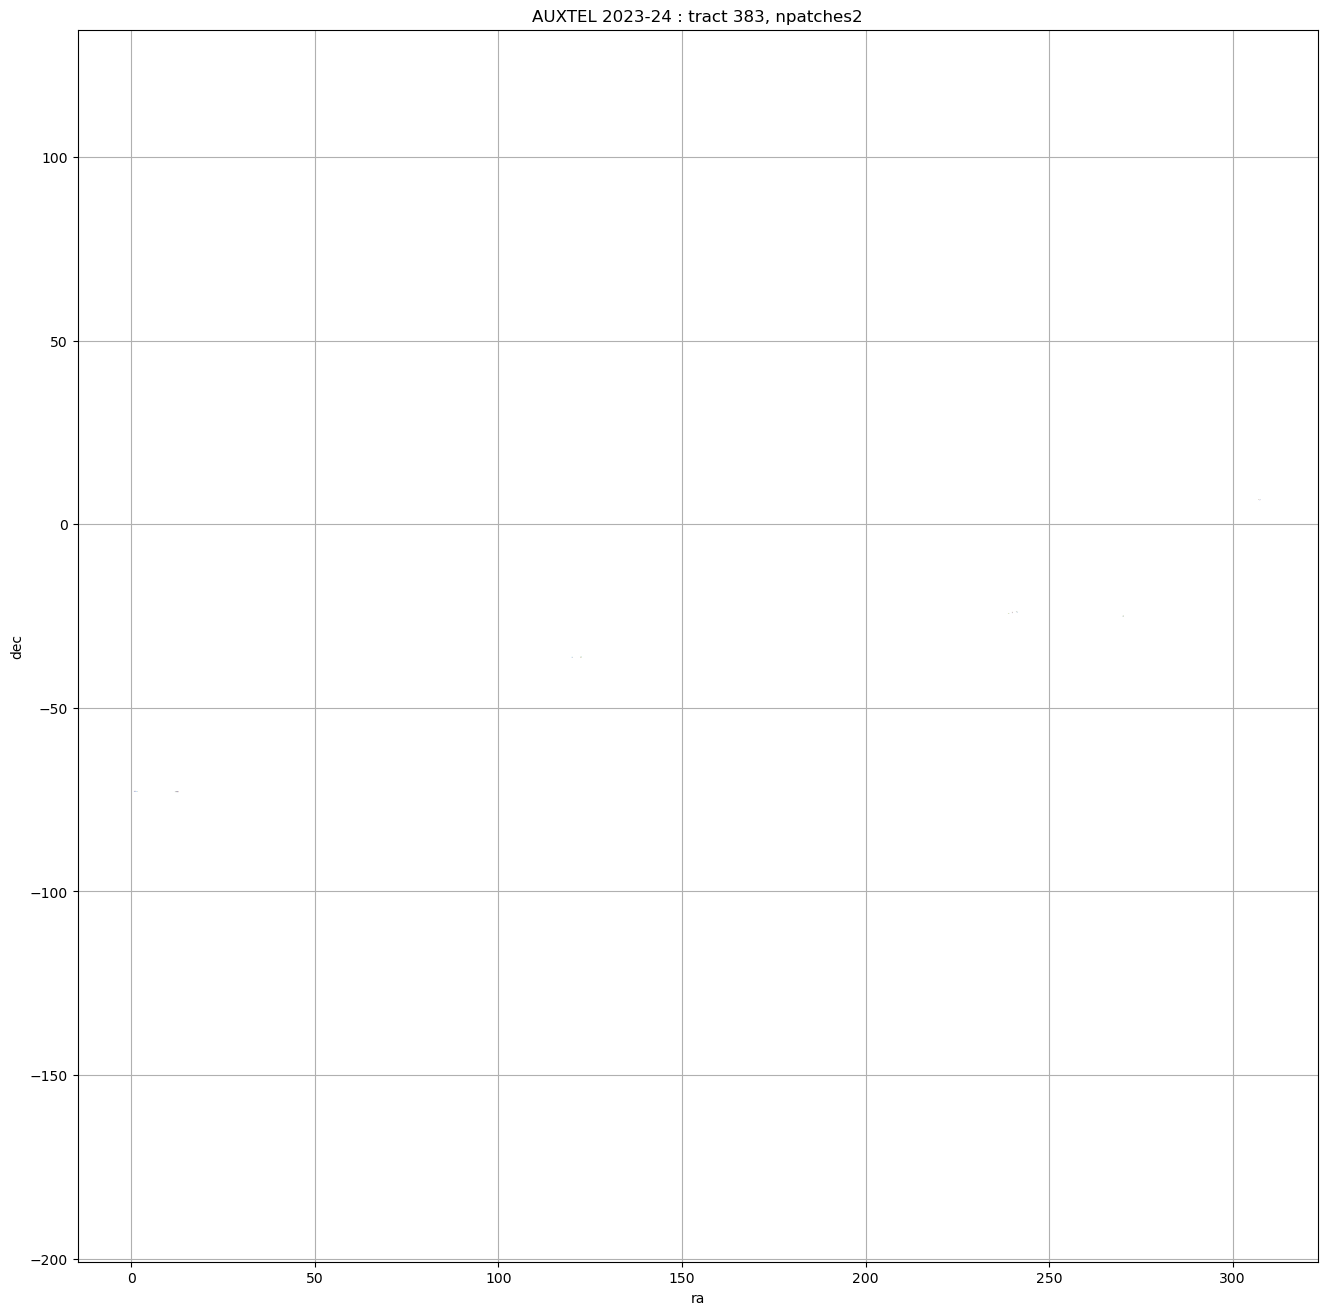

In [18]:
fig, ax = plt.subplots(figsize=(16,16))

# loop on tracts
for itract in list_of_tracts:

   
    # extract the Polygons    
    patches = tract_polygon_dict[itract]

    # find color
    nPatches = len(tracts_patchs_dict[itract])
    sns.color_palette("hls", nPatches)
    my_cmap = ListedColormap(sns.color_palette("hls", nPatches))

    ra = tract_ra_dict[itract]
    dec = tract_dec_dict[itract]
    Xmin = ra.min()
    Xmax = ra.max()
    Ymin = dec.min()
    Ymax = dec.max()
    
    p = PatchCollection(patches, cmap=mpl.cm.jet, alpha=0.4)
    #p = PatchCollection(patches, cmap=my_cmap, alpha=1)

    colors = 50*np.random.rand(len(patches))
    p.set_array(np.array(colors))

    ax.add_collection(p)  

ax.set_xlim([0,300.])
ax.set_ylim([-80., 10.])

title = f"AUXTEL 2023-24 : tract {itract}, npatches{nPatches}"
ax.set_title(title)
ax.set_xlabel("ra")
ax.set_ylabel("dec")
#plt.gca().set_aspect('equal')
ax.axis('equal')
ax.grid()
plt.show()

## Plot tract One by One

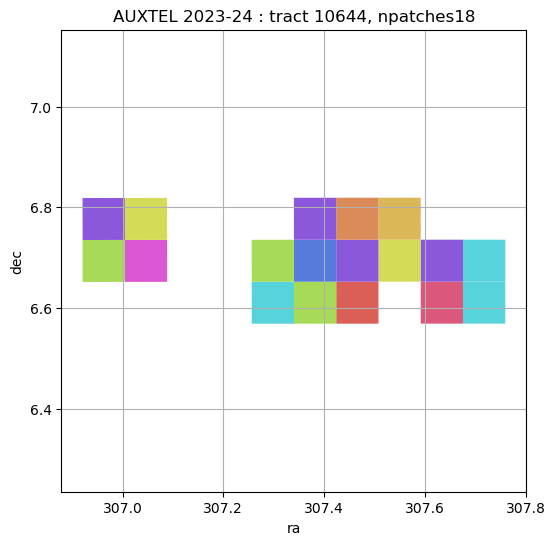

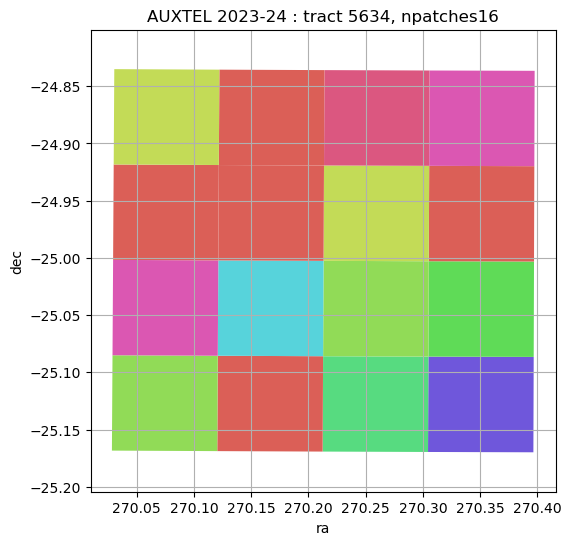

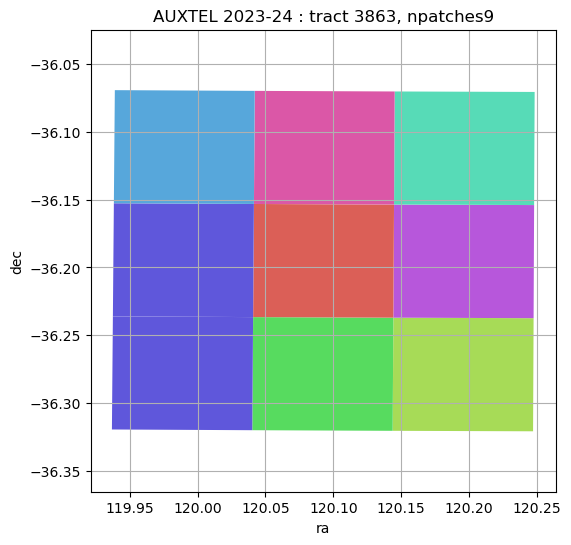

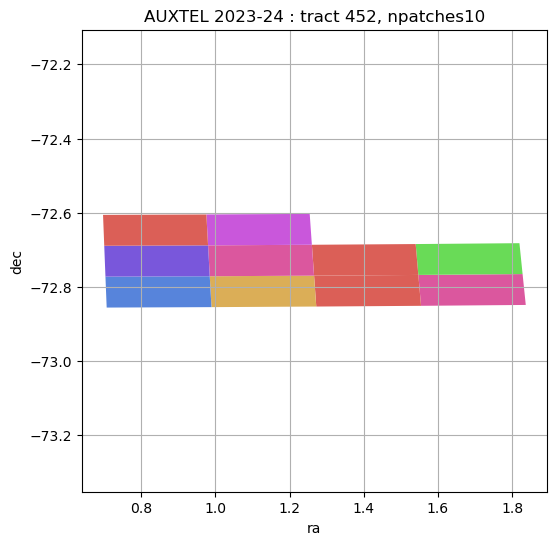

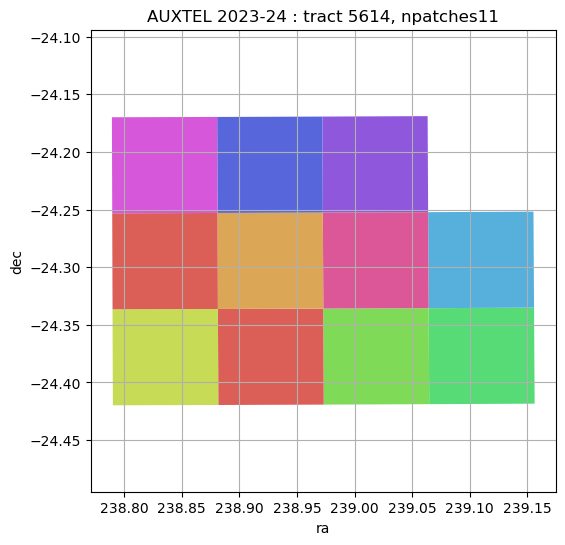

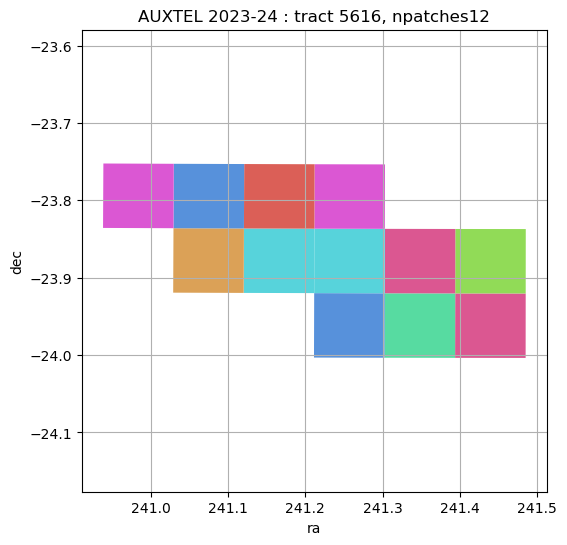

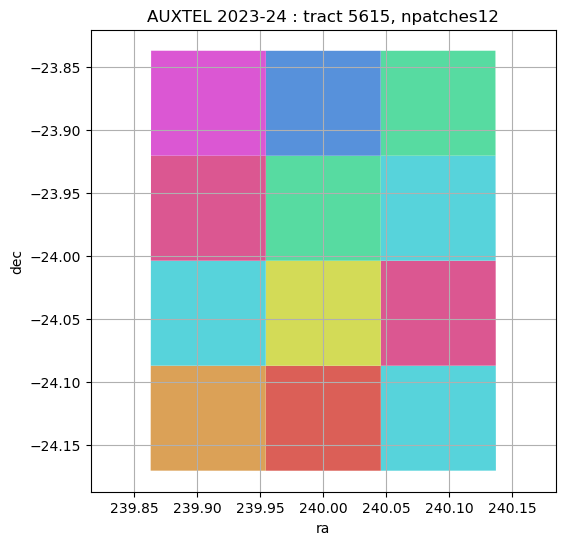

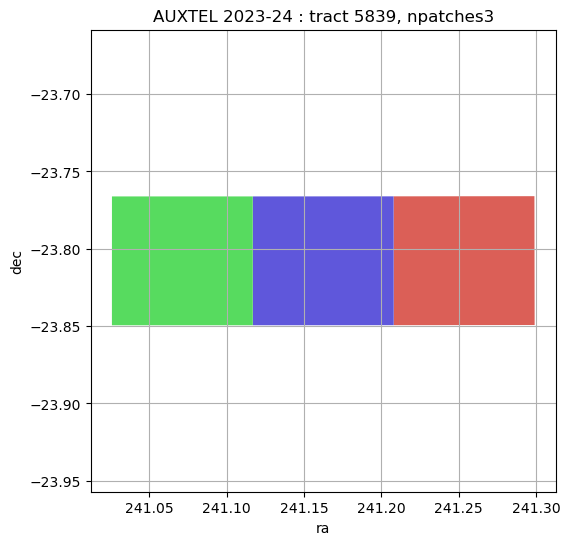

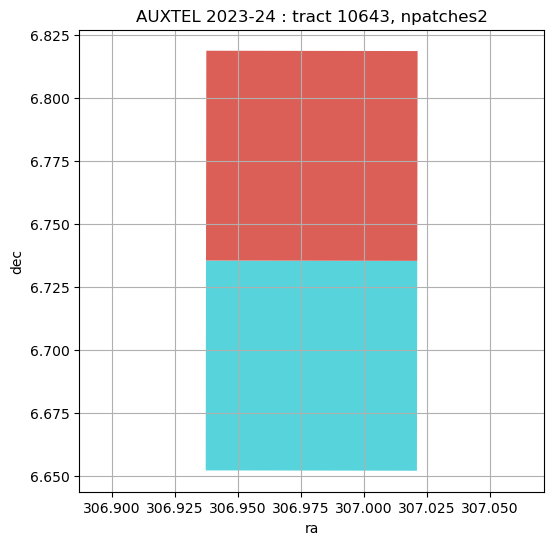

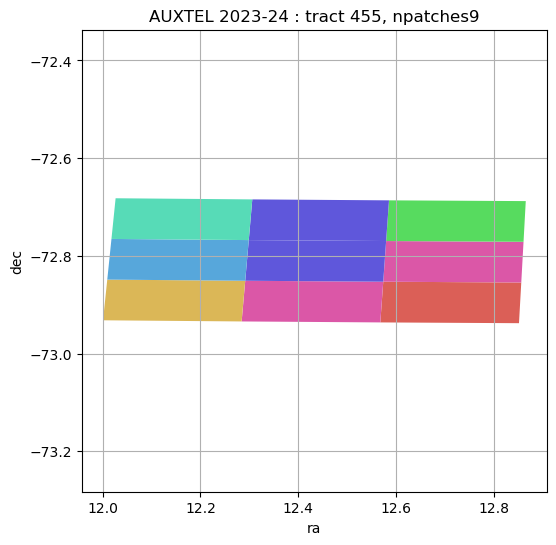

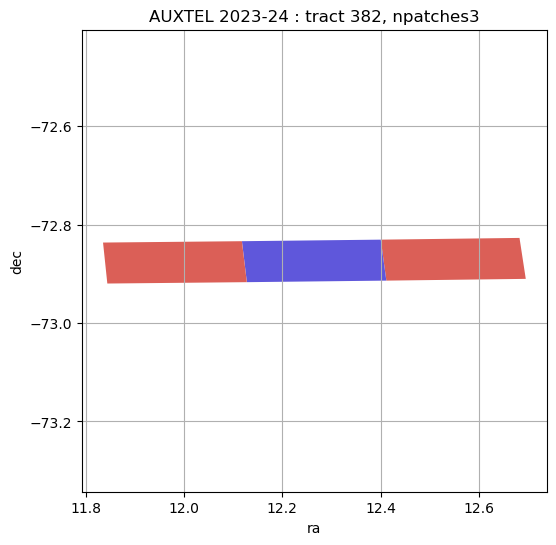

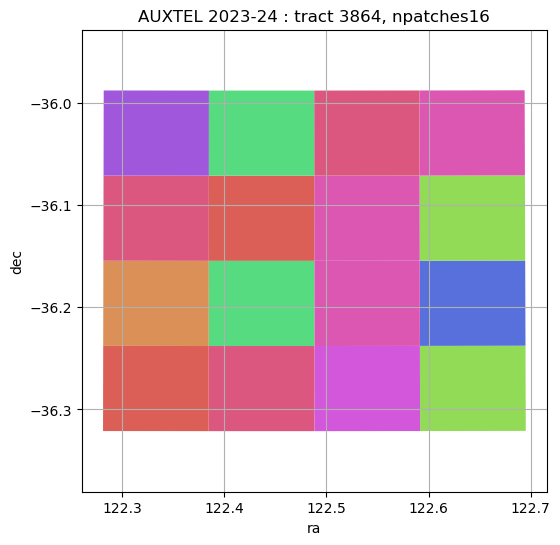

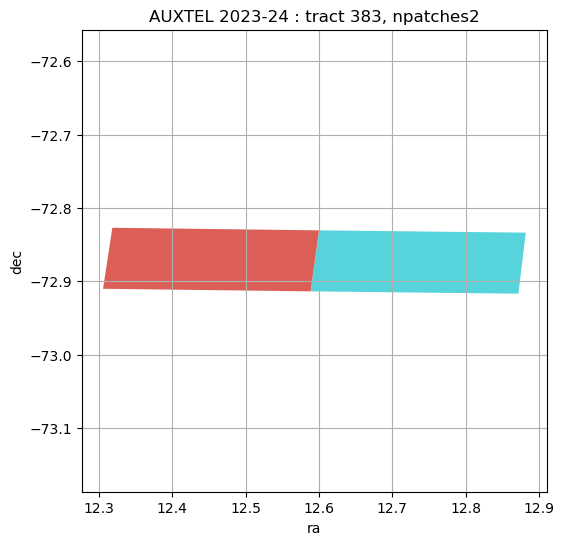

In [19]:
# loop on tracts
for itract in list_of_tracts:

   
    # extract the Polygons    
    patches = tract_polygon_dict[itract]

    # find color
    nPatches = len(tracts_patchs_dict[itract])
    sns.color_palette("hls", nPatches)
    my_cmap = ListedColormap(sns.color_palette("hls", nPatches))

    ra = tract_ra_dict[itract]
    dec = tract_dec_dict[itract]
    Xmin = ra.min()
    Xmax = ra.max()
    Ymin = dec.min()
    Ymax = dec.max()
    

    fig, ax = plt.subplots(figsize=(6,6))
    #p = PatchCollection(patches, cmap=mpl.cm.jet, alpha=0.4)
    p = PatchCollection(patches, cmap=my_cmap, alpha=1)

    #colors =   my_cmap.colors
    #p.set_array(np.array(colors))
    colors = 64*np.random.rand(len(patches))
    p.set_array(np.array(colors))

    ax.add_collection(p)  

    ax.set_xlim([Xmin,Xmax])
    ax.set_ylim([Ymin, Ymax])

    title = f"AUXTEL 2023-24 : tract {itract}, npatches{nPatches}"
    ax.set_title(title)
    ax.set_xlabel("ra")
    ax.set_ylabel("dec")
    #plt.gca().set_aspect('equal')
    ax.axis('equal')
    ax.grid()
    plt.show()